In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import matplotlib.pyplot as plt

In [2]:
"""
To ignore the pandas SettingWithCopyWarning in cell 5 function time_for_phase
If you have the solution to optimize the function please contact :)
"""
import warnings
warnings.filterwarnings('ignore')

In [3]:
from data_access.load_file import *
from data_processing.functions import *

Select the columns

In [4]:
relevant_columns = ["work_item", "timestamp", "process_phase"]

In [5]:
duration_type = ["duration_in_days"]

Compute times for every process phase

In [6]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
data.sort_values(by='timestamp', inplace=True)
data = add_phase(data, col_name="process_phase", cols=["from_phase", "to_phase"], as_str=False)
#data = add_phase(data, col_name="resource_phase", cols=["from_resource", "to_resource"], as_str=False)
times = time_for_phase(data, relevant_columns=relevant_columns, end_date=None)

Rename and order columns

In [7]:
new_names = {
            "to_phase": "current_phase",
            "process_phase_x": "from_process",
            "timestamp_x": "from_timestamp",
            "timestamp_y": "to_timestamp",
            "process_phase_y": "to_process"
            }
times.rename(columns=new_names, inplace=True)
relevant_cols = ["work_item", "process_index", "from_process", "to_process", "from_timestamp", "to_timestamp", *duration_type]
times= times[relevant_cols]

In [8]:
times.head()

,work_item,process_index,from_process,to_process,from_timestamp,to_timestamp,duration_in_days
0,WI_000001,1,"(Start, Analyze)","(Analyze, Design)",2015-01-02 14:39:14,2015-01-05 11:48:08,2.88
1,WI_000002,1,"(Start, Analyze)","(Analyze, Design)",2015-01-02 15:04:20,2015-01-14 09:46:19,11.78
2,WI_000003,1,"(Start, Analyze)","(Analyze, Design)",2015-01-02 15:28:22,2015-01-21 11:37:06,18.84
3,WI_000004,1,"(Start, Analyze)","(Analyze, Design)",2015-01-02 15:33:54,2015-01-14 10:41:26,11.80
4,WI_000005,1,"(Start, Analyze)","(Analyze, Design)",2015-01-02 16:32:11,2015-01-28 09:03:38,25.69


Split into work items with and without an end

In [9]:
is_open = pd.isnull(times["duration_in_days"])
times_open = times[is_open]
times_closed = times[~is_open]

In [10]:
end_wi = times_closed[times_closed["to_process"].apply(lambda x: "End" in str(x))].work_item.values
closedend = times_closed[times_closed["work_item"].isin(end_wi)]
openend = times_closed[~times_closed["work_item"].isin(end_wi)]

In [11]:
print("There are %i work items with an end and %i with an open end"%(closedend.work_item.nunique(), openend.work_item.nunique()))

There are 10522 work items with an end and 526 with an open end


Get the correlation between the starting time and the duration to work on a work item

In [12]:
plot_df = pd.DataFrame(times_closed.groupby("work_item")["duration_in_days"].sum()).reset_index()
plot_df = plot_df.merge(times_closed[times_closed["process_index"]==1][["work_item", "from_timestamp"]])
plot_df.index = plot_df["work_item"]

In [13]:
closedend = plot_df[plot_df["work_item"].isin(end_wi)]
openend = plot_df[~plot_df["work_item"].isin(end_wi)]

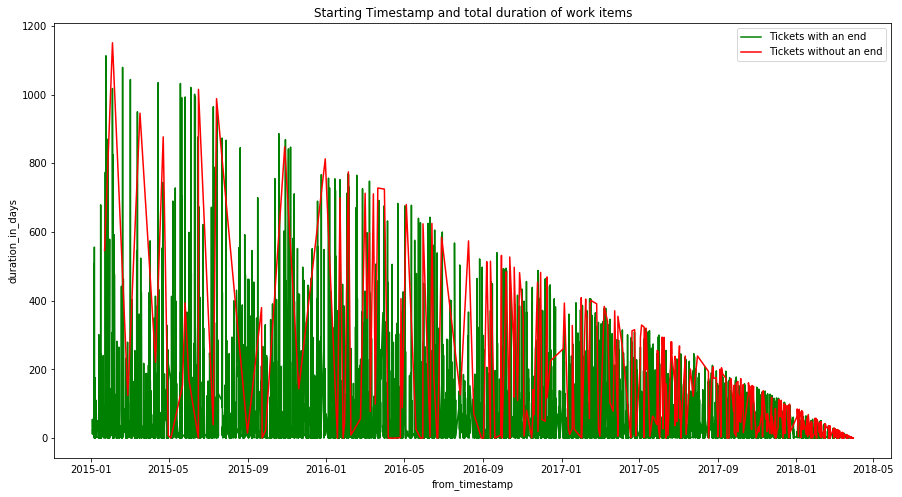

In [14]:
plt.figure(figsize=(15,8))
plt.plot(closedend["from_timestamp"], closedend["duration_in_days"], color='g', label="Tickets with an end")
plt.plot(openend["from_timestamp"], openend["duration_in_days"], color='r', label="Tickets without an end")
plt.title("Starting Timestamp and total duration of work items")
plt.xlabel("from_timestamp")
plt.ylabel("duration_in_days")
plt.legend()
plt.show()

One can see like in the eda's before: the more recent the starting timestamp the less time is needed to close a work item.
One can also see the increasing number of work items without an end.

Let's have a look on the distribution of the duration

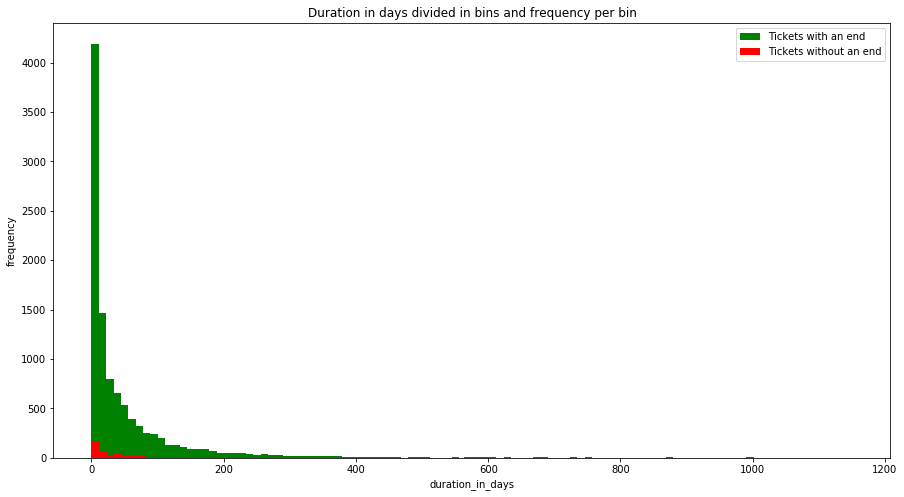

In [15]:
plt.figure(figsize=(15,8))
plt.hist(x=closedend["duration_in_days"], bins=100, color='green', label="Tickets with an end")
plt.hist(x=openend["duration_in_days"], bins=100, color='red', label="Tickets without an end")
plt.title("Duration in days divided in bins and frequency per bin")
plt.xlabel("duration_in_days")
plt.ylabel("frequency")
plt.legend()
plt.show()

We can see that most of the work items with an end are done in a short perion of time. Looks like a exponential distribution.
Let's have a look on the arise of work items per time to see if the decline of duration in recent time periods are because of less work items

In [16]:
closedend.index = closedend.from_timestamp
closedend.index = pd.PeriodIndex(closedend.index, freq="M")
closed_agg = pd.DataFrame(closedend.groupby(closedend.index)["work_item"].nunique())
openend.index = openend.from_timestamp
openend.index = pd.PeriodIndex(openend.index, freq="M")
open_agg = pd.DataFrame(openend.groupby(openend.index)["work_item"].nunique())
merged_agg = pd.merge(closed_agg, open_agg, left_index=True, right_index=True)
merged_agg.rename(columns={"work_item_x":"new_wi_with_end", "work_item_y":"new_wi_without_end"}, inplace=True)

In [17]:
maxproc = pd.DataFrame(times_closed.groupby("work_item")["process_index"].max())
maxproc.reset_index(inplace=True)
merged = pd.merge(maxproc, times_closed)
merged = merged[["work_item", "to_timestamp"]]
merged.index = merged["to_timestamp"]
merged.index = pd.PeriodIndex(merged.index, freq='M')
end_agg = pd.DataFrame(merged.groupby(merged.index)["work_item"].nunique())
end_agg.rename(columns={"work_item":"closing_wi"}, inplace=True)

In [18]:
merged_agg = pd.merge(merged_agg, end_agg, left_index=True, right_index=True)

In [19]:
merged_agg.loc[:, "dela"] = merged_agg["new_wi_with_end"] - merged_agg["closing_wi"]

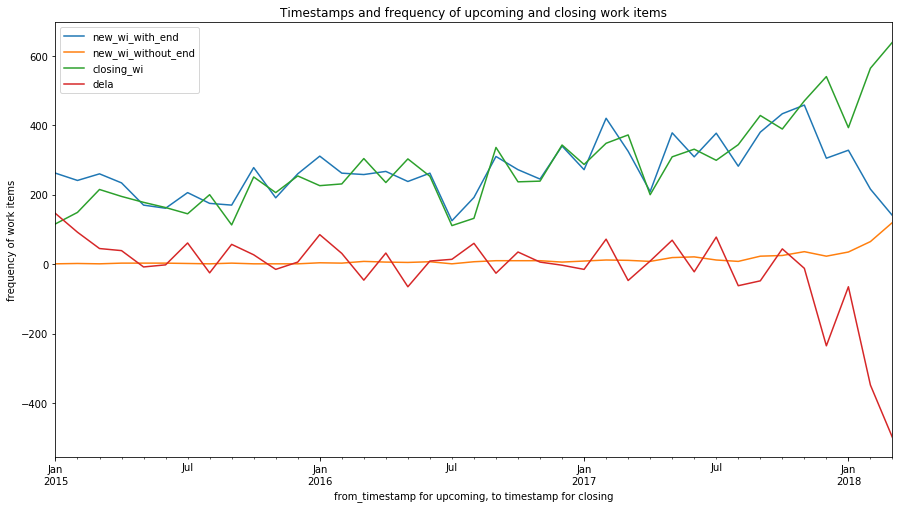

In [20]:
merged_agg.plot(figsize=(15,8))
plt.title("Timestamps and frequency of upcoming and closing work items")
plt.xlabel("from_timestamp for upcoming, to timestamp for closing")
plt.ylabel("frequency of work items")
plt.legend()
plt.show()

This is quite interesting. The arise of work tickets seems to have multiple factors.
One could be the vacation time in summer, because the graph decreases in summer months.
There is also an increase at the beginning of the year which could be because of some releases at the end of the previous year.

New opened and closed work items are almost balanced until November/Dezember 2018 so this might be a timestamp to cut for validation set